In [1]:
# the files were downloaded from https://github.com/immunitastx/coding_exercises
# I would have to assume that we work with normalized values (as provided by Kalisto, Salmon, Sailfish)
# If the gene expression values reflect the raw counts, we will have to use limma, edgeR, or DESeq2.

In [2]:
library("ggplot2")
library("reshape2")
library("dplyr")
library("tidyr")
library("nortest")
library("pheatmap")
library("car")
library("nortest")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




In [3]:
# Approach Outline:

In [4]:
# 1. Data Reading: import the dataset for analysis.

# 2. Exploratory Data Analysis (EDA):

# 2.1. Dimensionality Reduction: PCA and MDS to identify clusters in the data.

# 2.2. Hierarchical Clustering to detect clusters, complemented by PCA and MDS.

# 2.3. Make scatter plots to compare average expression values between Condition 1 and Condition 2.

# 3. Normality Check: Assess whether gene expression data for each gene follows a normal distribution in both Condition 1 and Condition 2.

# 4. Variance Equality Check: Determine if gene expression data exhibits equal variance between Condition 1 and Condition 2.

# Observations: A large number of genes show Gaussian distribution and equal variance in their expression levels.

# 5. Statistical Testing: Apply a t-test assuming equal variance, or more robustly, use Welch’s t-test to account for any variance differences.

# 6. Correction for Multiple Testing: use FDR correction to adjust p-values for multiple comparisons.        

In [5]:
# 1. Data Reading: import the dataset for analysis.

In [6]:
condition = read.table("condition.tsv", header = T, sep ="\t", stringsAsFactors = FALSE)
head(condition, 2)

omics = read.table("omics.tsv", header = T, sep ="\t", stringsAsFactors = FALSE)
head(omics, 2)

# Counting the number of cells in Condition1 and in Condition2
print("the number of cells in condition1 and in condition2")
count_condition_cells <- table(condition$condition)
print(count_condition_cells)

,X,condition
,<chr>,<chr>
1,cell_0,condition_1
2,cell_1,condition_1


,X,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,⋯,gene_490,gene_491,gene_492,gene_493,gene_494,gene_495,gene_496,gene_497,gene_498,gene_499
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cell_0,8.629958,10.982940,7.266632,10.678859,12.872255,8.340998,1.575487,9.500035,12.92376,⋯,15.78759,12.52753,15.694514,10.59571,9.234829,7.193928,15.79747,10.99470,8.697663,20.51743
2,cell_1,14.184409,5.969177,9.096169,5.425243,8.447623,10.845491,12.114656,8.309813,10.49471,⋯,12.02923,15.07091,9.020268,10.87630,10.083817,13.194958,5.74405,14.92864,20.693333,11.22486


[1] "the number of cells in condition1 and in condition2"

condition_1 condition_2 
        600         400 


In [7]:
x = merge(condition, omics, by = "X")
head(x,2)

y = x %>% select(-X)
head(y,2)
dim(y)

# z = t(y)
# head(z,4)
# dim(z)
# we can work with either z or y data frame

,X,condition,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,⋯,gene_490,gene_491,gene_492,gene_493,gene_494,gene_495,gene_496,gene_497,gene_498,gene_499
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cell_0,condition_1,8.629958,10.982940,7.266632,10.678859,12.872255,8.340998,1.575487,9.500035,⋯,15.78759,12.52753,15.694514,10.59571,9.234829,7.193928,15.79747,10.99470,8.697663,20.51743
2,cell_1,condition_1,14.184409,5.969177,9.096169,5.425243,8.447623,10.845491,12.114656,8.309813,⋯,12.02923,15.07091,9.020268,10.87630,10.083817,13.194958,5.74405,14.92864,20.693333,11.22486


,condition,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,⋯,gene_490,gene_491,gene_492,gene_493,gene_494,gene_495,gene_496,gene_497,gene_498,gene_499
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,condition_1,8.629958,10.982940,7.266632,10.678859,12.872255,8.340998,1.575487,9.500035,12.92376,⋯,15.78759,12.52753,15.694514,10.59571,9.234829,7.193928,15.79747,10.99470,8.697663,20.51743
2,condition_1,14.184409,5.969177,9.096169,5.425243,8.447623,10.845491,12.114656,8.309813,10.49471,⋯,12.02923,15.07091,9.020268,10.87630,10.083817,13.194958,5.74405,14.92864,20.693333,11.22486


[1] 1000  501

In [8]:
# checking whether we have any NA : 

total_na_count <- sum(is.na(y))

cat("Total number of NA values in the data frame:\n")
print(total_na_count)

Total number of NA values in the data frame:
[1] 0


In [9]:
# using dplyr / tidyr / tidyverse functions to reformat the data

In [10]:
y_long <- y %>%
  pivot_longer(cols = -condition, names_to = "gene", values_to = "expression")

head(y_long, 2)
tail(y_long, 2)
dim(y_long)

condition,gene,expression
<chr>,<chr>,<dbl>
condition_1,gene_0,8.629958
condition_1,gene_1,10.982940


condition,gene,expression
<chr>,<chr>,<dbl>
condition_2,gene_498,1.988435
condition_2,gene_499,8.814940


[1] 500000      3

In [11]:
# 2. Exploratory Data Analysis (EDA):

In [12]:
# 2.1. Dimensionality Reduction: PCA and MDS to identify clusters in the data.

In [13]:
# PCA

[1] "PCA shows good separability of the expression data"


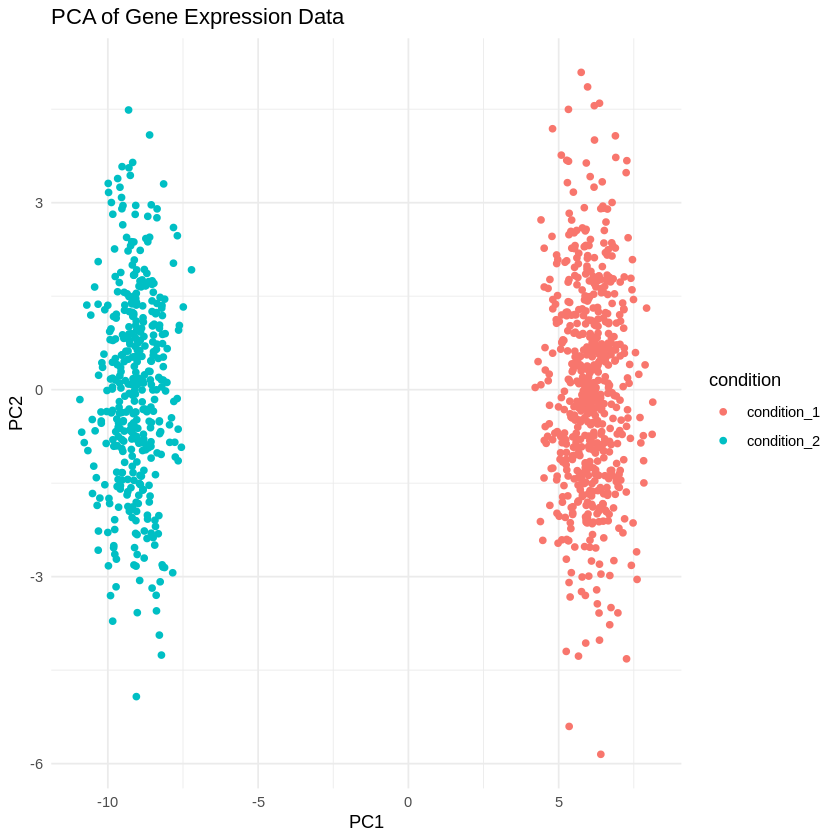

In [14]:
y_pca <- y %>%
  select(-condition) 

# Perform PCA and display the results
pca_result <- prcomp(y_pca, scale. = TRUE)
# summary(pca_result)

pca_scores <- as.data.frame(pca_result$x)
pca_scores$condition <- y$condition


ggplot(pca_scores, aes(x = PC1, y = PC2, color = condition)) +
  geom_point() +
  labs(title = "PCA of Gene Expression Data",
       x = "PC1",
       y = "PC2") +
  theme_minimal()

print("PCA shows good separability of the expression data")

In [15]:
# MDS

[1] "MDS shows good separability of the expression data"


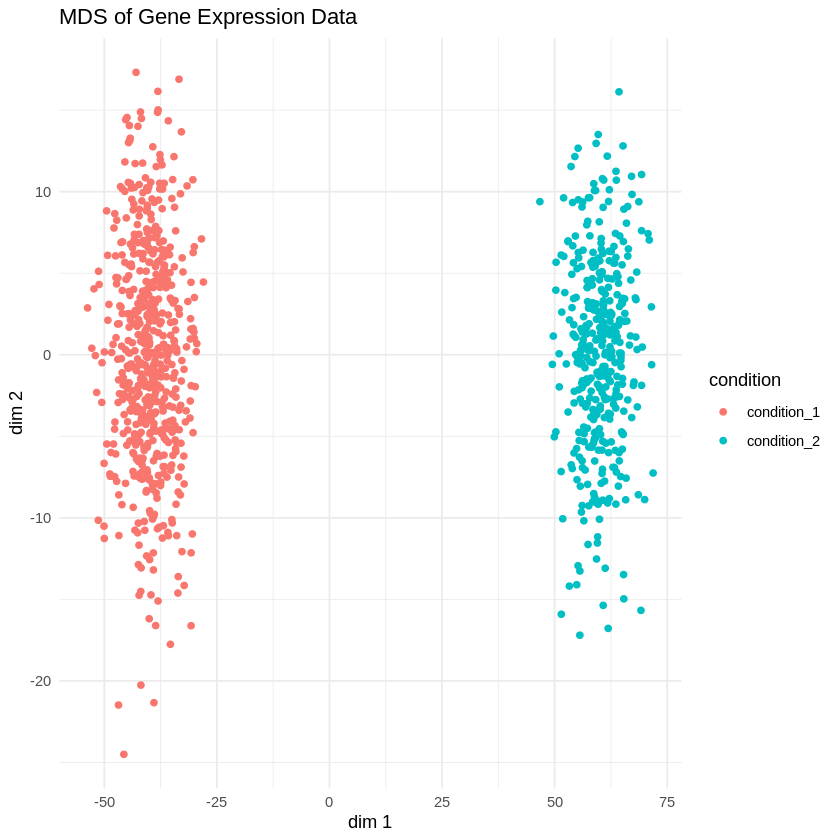

In [16]:
y_mds <- y %>%
  select(-condition) 

# Compute the distance matrix and perform MDS

distance_matrix <- dist(y_mds)
mds_result <- cmdscale(distance_matrix, k = 2)
mds_scores <- as.data.frame(mds_result)
mds_scores$condition <- y$condition

ggplot(mds_scores, aes(x = V1, y = V2, color = condition)) +
  geom_point() +
  labs(title = "MDS of Gene Expression Data",
       x = "dim 1",
       y = "dim 2") +
  theme_minimal()

print("MDS shows good separability of the expression data")

In [17]:
# 2.3. Make scatter plots to compare average expression values between Condition 1 and Condition 2.

`summarise()` has grouped output by 'condition'. You can override using the `.groups` argument.


gene,average_condition_1,average_condition_2
<chr>,<dbl>,<dbl>
gene_0,10.06228,9.685134
gene_1,10.01636,10.051854


gene,average_condition_1,average_condition_2
<chr>,<dbl>,<dbl>
gene_98,9.959729,10.19318
gene_99,9.739013,10.15590


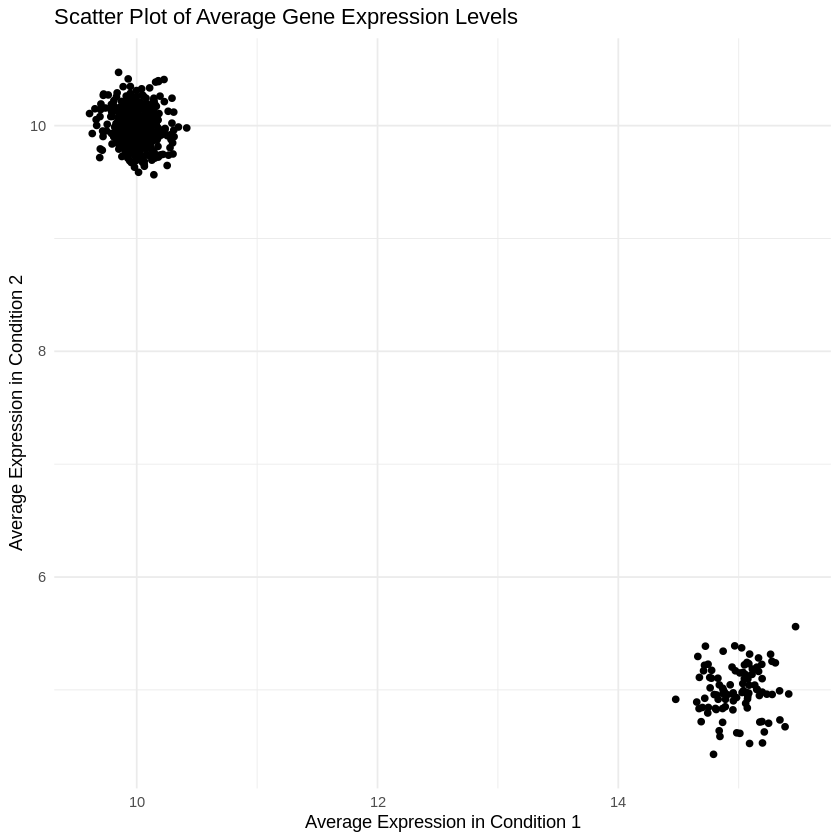

In [18]:
# Calculate the average expression for each gene in each condition

average_expression <- y_long %>%
  group_by(condition, gene) %>%
  summarise(average_expression = mean(expression, na.rm = TRUE)) %>%
  pivot_wider(names_from = condition, values_from = average_expression, names_prefix = "average_") 

head(average_expression, 2)
tail(average_expression, 2)

# Make the scatter plot
ggplot(average_expression, aes(x = average_condition_1, y = average_condition_2)) +
  geom_point() +
  labs(title = "Scatter Plot of Average Gene Expression Levels",
       x = "Average Expression in Condition 1",
       y = "Average Expression in Condition 2") +
  theme_minimal()

In [19]:
# 2.2. Hierarchical Clustering to detect clusters

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V991,V992,V993,V994,V995,V996,V997,V998,V999,V1000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gene_0,8.629958,14.184409,8.185158,4.316196,8.027771,8.824219,9.470685,9.145110,6.508461,18.18654,⋯,7.925398,8.208675,13.509209,11.64163,6.651866,7.564224,13.22669,12.906168,13.881772,9.505887
gene_1,10.982940,5.969177,8.023956,8.273040,6.480139,10.013495,5.221169,9.026718,10.095176,12.05225,⋯,11.341293,4.942110,8.770986,10.49487,12.679266,11.170408,14.22153,7.576392,5.629495,14.953901


[1] "Hierarchical clustering of the genes :"


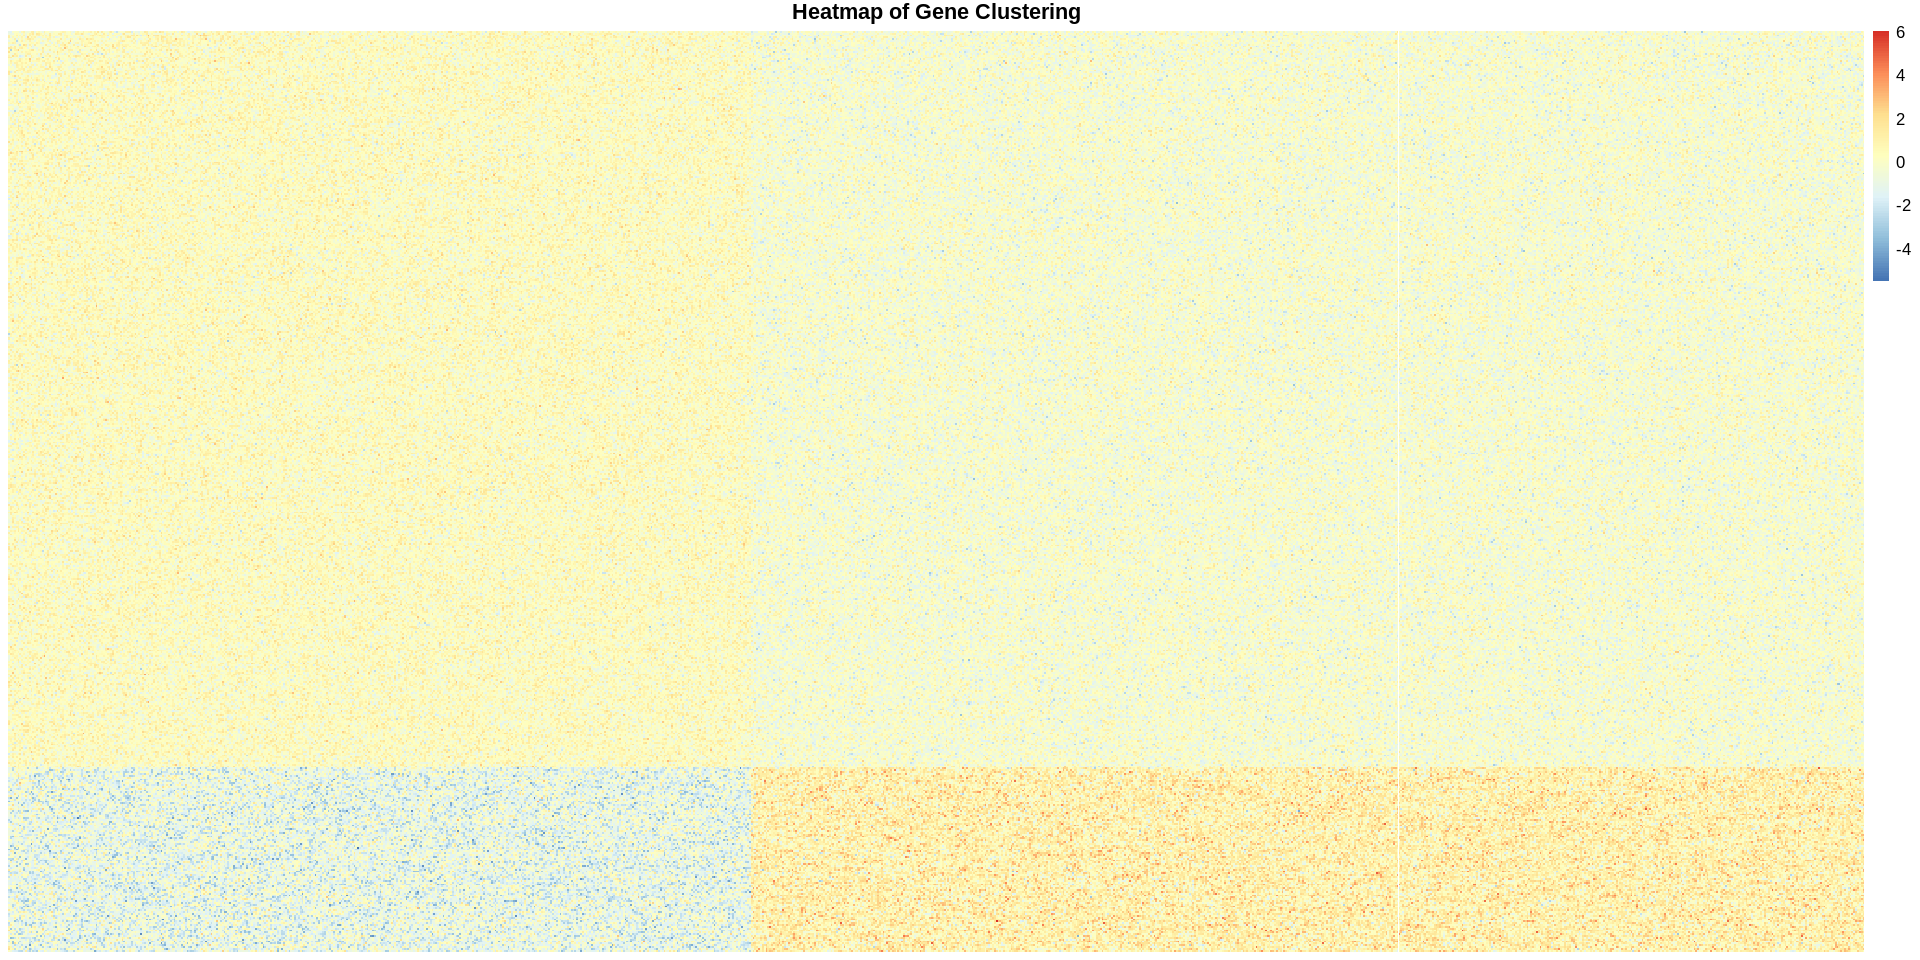

In [20]:
z_long <- y %>%
  select(-condition) %>%
  t() %>%
  as.data.frame()

# Set column names to the first row and remove the first row
head(z_long, 2)
colnames(z_long) <- z_long[1,]

z_long <- as.data.frame(lapply(z_long, as.numeric))

# Scale the data
z_scaled <- scale(z_long)
dist_matrix <- dist(z_scaled)

# Perform hierarchical clustering
hc <- hclust(dist_matrix, method = "complete")

# Plot the dendrogram
# plot(hc, main = "Hierarchical Clustering of Genes")

print("Hierarchical clustering of the genes :")

options(repr.plot.width=16, repr.plot.height=8)
pheatmap(z_scaled, 
         cluster_rows = TRUE, 
         cluster_cols = TRUE,
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         treeheight_row = 0,          # Set tree height for rows to 0 (hide dendrogram)
         treeheight_col = 0, 
         main = "Heatmap of Gene Clustering")      

In [21]:
# Exploratory data analysis

In [22]:
# The density plots of the genes in Condition_1 and in _Condition_2

In [23]:
# y_long <- y %>%
#  pivot_longer(cols = -condition, names_to = "gene", values_to = "expression")
# head(y_long, 2)
# dim(y_long)

# The Density Plots of the expression of ALl the genes in Condition 1 and in Condition 2
# ggplot(y_long, aes(x = expression, fill = condition)) +
#  geom_density(alpha = 0.5) +
#  labs(title = "Density Plots of Gene Expressions",
#       x = "Expression Values",
#       y = "Density") +
#  theme_minimal()

# expression_condition_1 <- y_long %>%
#  filter(condition == 'condition_1') %>%
#  pull(expression)

# expression_condition_2 <- y_long %>%
#  filter(condition == 'condition_2') %>%
#  pull(expression)

# using Anderson-Darling Test to check the Gaussian Distribution of the expression of all the genes in those two conditions
# ad.test(expression_condition_1)
# ad.test(expression_condition_2)

# print("the results of AD test indicate that there is strong evidence that the data deviates significantly from a normal distribution")

In [24]:
# 3. Normality Check: Assess whether gene expression data for each gene follows a normal distribution in both Condition 1 and Condition 2.

In [25]:
# A function to apply Anderson-Darling test and check normality of the gene expression distribution

check_normality <- function(expression_values) {
  result <- ad.test(expression_values)
  return(result$p.value)
}

# Apply Anderson-Darling test to each gene and each condition

normality_results <- y_long %>%
  group_by(condition, gene) %>%
  summarise(p_value = check_normality(expression)) %>%
  ungroup()

dim(normality_results)

# Define a significance level
alpha <- 0.05

# Count how many genes follow a normal distribution in each condition

normal_genes_count <- normality_results %>%
  group_by(condition) %>%
  summarise(normal_genes = sum(p_value > alpha)) %>%
  ungroup()

# Print the results
# print(normality_results)
print("the number of the genes that follow a normal distribution :")
print(as.data.frame(normal_genes_count))

# Count how many genes do not follow a normal distribution in each condition

non_normal_genes_count <- normality_results %>%
  group_by(condition) %>%
  summarise(non_normal_genes = sum(p_value <= alpha)) %>%
  ungroup()

# Print the results
# print(normality_results)
print("the number of the genes that do not follow a normal distribution :")
print(as.data.frame(non_normal_genes_count))

print("as we can see a large majority of the genes follow a normal distribution")

`summarise()` has grouped output by 'condition'. You can override using the `.groups` argument.


[1] 1000    3

[1] "the number of the genes that follow a normal distribution :"
    condition normal_genes
1 condition_1          473
2 condition_2          477
[1] "the number of the genes that do not follow a normal distribution :"
    condition non_normal_genes
1 condition_1               27
2 condition_2               23
[1] "as we can see a large majority of the genes follow a normal distribution"


In [26]:
# 4. Variance Equality Check: Determine if gene expression data exhibits equal variance between Condition 1 and Condition 2.

In [27]:
# I would like to double check the equality of VARIANCES : we use VAR.TEST (F.TEST)
# Testing the equality of Variances for each gene in order to assess Homoscedasticity or Heteroscedasticity 

In [28]:
test_equal_variance <- function(expression_condition_1, expression_condition_2) {
  var_test <- var.test(expression_condition_1, expression_condition_2)
  return(var_test$p.value)
}

# Pivot the data to get separate columns for each condition
# Gene are on the row, and the expression data in Condition 1 and in Condition 2 is contained in LISTS

variance_results <- y_long %>%
  pivot_wider(names_from = condition, values_from = expression) %>%
  group_by(gene) %>%
  rowwise() %>%
  mutate(p_value = test_equal_variance(condition_1, condition_2)) %>%
  ungroup()

# Define a significance level
alpha <- 0.05

# Count how many genes have equal variance
equal_variance_genes_count <- variance_results %>%
  summarise(equal_variance_genes = sum(p_value > alpha)) %>%
  pull(equal_variance_genes)  # pull value to get a single number

# Count how many genes do not have equal variance
total_genes_count <- nrow(variance_results)
different_variance_genes_count <- total_genes_count - equal_variance_genes_count

# Print the results
print("Number of gene whose expressions have equal or different variances in Condition 1 and in Condition 2 :")
print(paste("Number of genes with equal variance:", equal_variance_genes_count))
print(paste("Number of genes with different variance:", different_variance_genes_count))

Warning message:
“Values from `expression` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(gene, condition) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”


[1] "Number of gene whose expressions have equal or different variances in Condition 1 and in Condition 2 :"
[1] "Number of genes with equal variance: 479"
[1] "Number of genes with different variance: 21"


In [29]:
# Observations: A large number of genes show Gaussian distribution and equal variance in their expression levels.

In [30]:
# Given the gaussian distribution of the data and its homoscedasticity, 
# we can apply T test to identify the genes with the differential expression.
# we can use the standard t.test with equal variances ; 
# t_test <- t.test(expression_condition_1, expression_condition_2, var.equal = TRUE)
# or Welch T-test, given the fact that several genes do not have equal variance : 
# t_test <- t.test(expression_condition_1, expression_condition_2

In [31]:
# 5. Statistical Testing: Apply a t-test assuming equal variance, or more robustly, use Welch’s t-test to account for any variance differences.

In [32]:
test_equal_expression  <- function(expression_condition_1, expression_condition_2) {
  t_test <- t.test(expression_condition_1, expression_condition_2)
  return(t_test$p.value)
}

# Pivot the data to get separate columns for each condition
# Genes are on the row, and the expression data in Condition 1 and in Condition 2 is contained in LISTS

expression  <- y_long %>%
  pivot_wider(names_from = condition, values_from = expression) %>%
  group_by(gene) %>%
  rowwise() %>%
  mutate(p_value = test_equal_expression (condition_1, condition_2)) %>%
  ungroup()

# Define a significance level
alpha <- 0.05

# Count how many genes have non-differential expression
equal_expression_genes_count <- expression  %>%
  summarise(equal_expression_genes = sum(p_value > alpha)) %>%
  pull(equal_expression_genes)  # pull value to get a single number

# Count how many genes are differentially expressed 
total_genes_count <- nrow(expression )
different_expression_genes_count <- total_genes_count - equal_expression_genes_count

# Print the results
print("Number of genes whose expressions have equal or different expression s in Condition 1 and in Condition 2:")
print(paste("Number of genes with equal expression :", equal_expression_genes_count))
print(paste("Number of genes with different expression :", different_expression_genes_count))

Warning message:
“Values from `expression` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(gene, condition) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”


[1] "Number of genes whose expressions have equal or different expression s in Condition 1 and in Condition 2:"
[1] "Number of genes with equal expression : 366"
[1] "Number of genes with different expression : 134"


In [33]:
# Printing the genes that are differentially expressed 

genes_differential_expression <- expression %>%
                                filter(p_value < alpha)  

print("The number of the genes with differential expression before FDR-correction :")
dim(genes_differential_expression)

print("Genes with differential expression:")
print(genes_differential_expression)

[1] "The number of the genes with differential expression before FDR-correction :"


[1] 134   4

[1] "Genes with differential expression:"
# A tibble: 134 × 4
   gene    condition_1 condition_2   p_value
   <chr>   <list>      <list>          <dbl>
 1 gene_8  <dbl [600]> <dbl [400]> 1.50e-158
 2 gene_10 <dbl [600]> <dbl [400]> 4.16e-160
 3 gene_12 <dbl [600]> <dbl [400]> 1.27e-179
 4 gene_15 <dbl [600]> <dbl [400]> 4.78e-160
 5 gene_16 <dbl [600]> <dbl [400]> 8.70e-161
 6 gene_18 <dbl [600]> <dbl [400]> 6.07e-162
 7 gene_20 <dbl [600]> <dbl [400]> 2.51e-151
 8 gene_22 <dbl [600]> <dbl [400]> 7.91e-162
 9 gene_25 <dbl [600]> <dbl [400]> 2.33e-171
10 gene_31 <dbl [600]> <dbl [400]> 4.37e-160
# ℹ 124 more rows


In [34]:
# 6. Correction for Multiple Testing: use FDR correction to adjust p-values for multiple comparisons.  

In [35]:
# Applying FDR correction : we use p.adjust

expression <- expression %>%
              mutate(adj_p_value = p.adjust(p_value, method = "fdr"))

# Count how many genes have non-differential expression
equal_expression_genes_count <- expression %>%
  summarise(equal_expression_genes = sum(adj_p_value > alpha)) %>%
  pull(equal_expression_genes) 

# Count how many genes are differentially expressed
total_genes_count <- nrow(expression)
different_expression_genes_count <- total_genes_count - equal_expression_genes_count

# Print the results
print("Number of genes whose expressions have equal or different expressions in Condition 1 and Condition 2:")
print(paste("Number of genes with equal expression:", equal_expression_genes_count))
print(paste("Number of genes with different expression:", different_expression_genes_count))

[1] "Number of genes whose expressions have equal or different expressions in Condition 1 and Condition 2:"
[1] "Number of genes with equal expression: 392"
[1] "Number of genes with different expression: 108"


In [36]:
# Filter and print the genes with different expressions (FDR-corrected)
genes_different_expression <- expression %>%
                filter(adj_p_value < alpha)  # Genes with significant differences after FDR correction

print("Genes with differential expression:")
print(as.data.frame(genes_differential_expression))

[1] "Genes with differential expression:"
        gene
1     gene_8
2    gene_10
3    gene_12
4    gene_15
5    gene_16
6    gene_18
7    gene_20
8    gene_22
9    gene_25
10   gene_31
11   gene_33
12   gene_57
13   gene_70
14   gene_71
15   gene_72
16   gene_74
17   gene_76
18   gene_81
19   gene_82
20   gene_85
21   gene_86
22   gene_94
23   gene_96
24   gene_99
25  gene_100
26  gene_105
27  gene_107
28  gene_114
29  gene_116
30  gene_119
31  gene_122
32  gene_130
33  gene_132
34  gene_137
35  gene_142
36  gene_146
37  gene_147
38  gene_148
39  gene_152
40  gene_154
41  gene_160
42  gene_161
43  gene_171
44  gene_175
45  gene_176
46  gene_178
47  gene_181
48  gene_183
49  gene_184
50  gene_195
51  gene_197
52  gene_200
53  gene_207
54  gene_214
55  gene_217
56  gene_222
57  gene_223
58  gene_226
59  gene_227
60  gene_239
61  gene_240
62  gene_242
63  gene_243
64  gene_246
65  gene_249
66  gene_255
67  gene_258
68  gene_261
69  gene_265
70  gene_268
71  gene_271
72  gene_274
73  gene_